In [1]:
import pandas as pd
import csv
from pathlib import Path
import numpy as np
import pickle

# general
from typing import TextIO, List, Tuple, Optional, Any
from dataclasses import dataclass

# Custom
from utils.Loggers import BaseLogger
from utils import helper_functions



[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\jojoshulk\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\jojoshulk\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


# Load reviews

The reviews will be loaded from the `reviews` folder. Each csv file consists of a beer/brewery which is unique.

In [22]:
# load the kaggle file to get the beer name
beers_df = pd.read_csv("beer_reviews.csv")
mapping: dict = beers_df[['beer_beerid', 'beer_name']].drop_duplicates().to_dict('list')
abv: dict = beers_df[['brewery_id', 'beer_beerid', 'beer_abv']].drop_duplicates().to_dict('list')

# generate dict with {beer_id: beer_name}
beer_mapping: dict = dict(zip(mapping.get("beer_beerid"), mapping.get("beer_name")))
abv_mapping: dict = dict(zip(zip(abv.get("brewery_id"),abv.get("beer_beerid")),abv.get("beer_abv")))

beers_df
# cleanup
del beers_df

In [28]:
from pprint import pprint

In [47]:
@dataclass
class BeerReview(object):
    rating: float
    text: str


class ReviewReader(BaseLogger):
    """Read reviews based on an input file"""

    def __init__(self, input_folder: str,
                 beer_mapping: dict,
                 abv_mapping: dict,
                 output_file: str = "beer_reviews_aggregated.csv",
                 *args, **kwargs):
        super().__init__(*args, **kwargs)
        self.input_folder: Path = Path(input_folder)
        self.beer_mapping: dict = beer_mapping
        self.abv_mapping: dict = abv_mapping
        self.output_file: Path = Path(output_file)
        self.writer: Optional[csv.writer] = None
        self.fw: Optional[TextIO] = None

    @property
    def header(self) -> List[str]:
        return ["brewery_name", "brewery_id",
                "beer_id", "beer_name", "beer_abv",
                "country", "style", "score",
                "rating_mean", "rating_std",
                "text"]

    def process_file(self, file_path: Path) ->  List[Any]:
        """
        Read the reviews based on the input file. Returns a list of reviews.     """
        with file_path.open(encoding="utf8") as f:

            rating = []
            text: str = ""

            for i, row in enumerate(csv.DictReader(f)):

                # create a review object and append info
                review: BeerReview = BeerReview(float(row["rating"]), row["text"])

                rating.append(review.rating)
                text +=  helper_functions.preprocess(review.text)

        # create a review with all info
        total_review = [row["brewery_name"], row["brewery_id"],
                        row["beer_id"], self.beer_mapping.get(int(row["beer_id"])),
                        self.abv_mapping.get((int(row["brewery_id"]), int(row["beer_id"]))),
                         row["Country"], row["Style"], row["Score"],
                         np.mean(rating), np.std(rating), text]
        f.close()

        return total_review

    def _writer(self) -> tuple:
        """Initiates a csv.writer method and returns it"""

        # open a new csv writer
        output_path: Path = self.output_file
        fw: TextIO = output_path.open(mode="w",encoding="utf8")
        writer = csv.writer(fw,lineterminator="\n")

        self.logger.info(f"Writer Created..")
        return writer, fw

    def aggregate_reviews(self) -> None:
        """Iterate over the folder and load the reviews"""

        # init writer & write header
        self.writer, self.fw = self._writer()
        self.writer.writerow(self.header)

        # iterate files
        self.logger.info(f"Started reading reviews.")
        for i, file in enumerate(self.input_folder.iterdir()):
            try:
                _reviews: List[Any] = self.process_file(file)
                self.writer.writerow(_reviews)

                if (i+1) % 50 == 0 and i > 0:
                    self.logger.info(f"{i+1} beers processed")

            except UnboundLocalError:
                continue

        self.logger.info(f"Total Beers: {i+1}")
        self.fw.close()
        self.logger.info(f"{self.output_file} closed.")


        return None


In [48]:
ReviewReader(input_folder="reviews",
             beer_mapping=beer_mapping,
             abv_mapping=abv_mapping,
             output_file="aggregated_reviews_test.csv").aggregate_reviews()

[2023-04-02 09:12:36,318] INFO [ReviewReader] - Writer Created..
[2023-04-02 09:12:36,320] INFO [ReviewReader] - Started reading reviews.
[2023-04-02 09:13:47,703] INFO [ReviewReader] - 100 beers processed
[2023-04-02 09:14:28,331] INFO [ReviewReader] - 150 beers processed
[2023-04-02 09:14:59,171] INFO [ReviewReader] - 200 beers processed
[2023-04-02 09:15:23,725] INFO [ReviewReader] - 250 beers processed
[2023-04-02 09:16:03,499] INFO [ReviewReader] - 300 beers processed
[2023-04-02 09:16:39,945] INFO [ReviewReader] - 350 beers processed
[2023-04-02 09:17:12,218] INFO [ReviewReader] - 400 beers processed
[2023-04-02 09:17:40,811] INFO [ReviewReader] - 450 beers processed
[2023-04-02 09:18:12,377] INFO [ReviewReader] - 500 beers processed
[2023-04-02 09:18:36,779] INFO [ReviewReader] - 550 beers processed
[2023-04-02 09:18:56,552] INFO [ReviewReader] - 600 beers processed
[2023-04-02 09:19:23,048] INFO [ReviewReader] - 650 beers processed
[2023-04-02 09:19:45,637] INFO [ReviewReader] 

In [45]:
df1 = pd.read_csv("aggregated_reviews_test.csv",
                 usecols = ['brewery_id', 'brewery_name',
                            'beer_id', 'beer_name', 'beer_abv',
                            'country', 'style', 'score',
                            'rating_mean', 'rating_std'])
df1.to_csv("aggregated_reviews_small.csv")

C:\Users\jojoshulk\AppData\Roaming\Python\Python37\site-packages\pandas\util\_decorators.py:311: ParserWarning: Length of header or names does not match length of data. This leads to a loss of data with index_col=False.
  return func(*args, **kwargs)


Index(['brewery_name', 'brewery_id', 'beer_id', 'beer_name', 'beer_abvcountry',
       'style', 'score', 'rating_mean', 'rating_std', 'text'],
      dtype='object')

# Generate Embeddings

In [1]:
!pip install -U sentence-transformers

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 86.0/86.0 KB 2.8 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.8/6.8 MB 51.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 47.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 199.8/199.8 KB 14.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.6/7.6 MB 31.5 MB/s eta 0:00:00
  Created wheel for sentence-transformers: filename=sentence_transformers-2.2.2-py3-none-any.whl size=125942 sha256=c4ab54e62d4ee2cb1ac4d9aeb4aaef400dbedee816df08bcf838a4e18f518bfa
  Stored in directory: /root/.cache/pip/wheels/71/67/06/162a3760c40d74dd40bc855d527008d26341c2b0ecf3e8e11f
Successfully built sentence-transformers


In [5]:
import pandas as pd
import csv
from pathlib import Path
import numpy as np

# general

from typing import TextIO, List, Optional, Any


from sentence_transformers import SentenceTransformer, util

sbert = SentenceTransformer('all-MiniLM-L6-v2')# load the pretrained model.


In [145]:
def calculate_embedding(review_list):
  """Calculates the sentence embedding for a reviews."""
  emb = []
  for r in review_list:
    emb.append(sbert.encode(r))

  return np.array(emb).mean(axis=0)

def calculate_embedding_style(style):
  """Calculates the sentence embedding of the beer style."""
  return sbert.encode(style)


def return_chunks(reviews):
  """
  Splits a long string of text into smaller chunks.

  Args:
    reviews (str): A long string of text.

  Returns:
    list of str: A list of smaller chunks of the original string, with a maximum length of 250 words and an overlap of 50 words.
  """
  target: int = len(reviews.split())
  reviews_list = []
  i = 0
  while i < target:
    reviews_list.append(" ".join(reviews.split()[i:i+250]))
    i+= 200

  return reviews_list


In [ ]:
df = pd.read_csv("aggreated_reviews.csv")
df["review_list"] = df.text.apply(lambda x: return_chunks(x))
df["embedding"] = df.review_list.apply(lambda x: calculate_embedding(x))

In [155]:
# open a file for writing binary data
with open('emdeddings.pkl', 'wb') as f:
    # use pickle.dump to save the data to the file
    pickle.dump(df["embedding"], f)

## Visualize embeddings

* We will use the embeddings generated in a 2-d space based on the beer style. Although this might not make sense,

In [136]:
from sklearn.decomposition import PCA

two_dim = PCA(random_state=0).fit_transform(pd.DataFrame(df["embedding"].to_list()))[:,:2]
two_dim

array([[-0.00770661, -0.03570786],
       [ 0.17925052, -0.02064081],
       [-0.10693823,  0.21297038],
       ...,
       [ 0.20311466, -0.04039518],
       [-0.05857297, -0.10982767],
       [ 0.30600354, -0.01535639]], dtype=float32)

In [214]:


from sklearn.cluster import KMeans
import matplotlib.pyplot as plt


# example training data
train_data = df['style'].apply(lambda x : calculate_embedding_style(x)).to_list()

# create KMeans clustering model
kmeans = KMeans(n_clusters=6, random_state=42)
kmeans.fit(train_data)

/usr/local/lib/python3.9/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


KMeans(n_clusters=6, random_state=42)

In [217]:
# find a representative for each embedding
styles = df['style'].apply(lambda x : calculate_embedding_style(x))
labels = []

for centroid, label in zip(kmeans.cluster_centers_, kmeans.labels_):
  _max = 0
  for i, style in enumerate(styles):
    sim = util.cos_sim(centroid.astype(float), style.astype(float))

    if sim > _max:
      _max = sim
      _index = i
  labels.append(df['style'].iloc[_index])


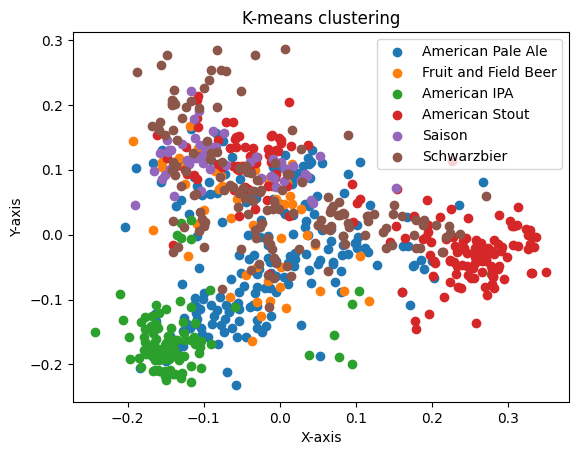

In [219]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn.cluster import KMeans


# Create a scatter plot for each cluster
fig, ax = plt.subplots()
for i in range(kmeans.n_clusters):
    mask = kmeans.labels_ == i
    plt.scatter(two_dim[mask, 0], two_dim[mask, 1],label=f'{labels[i]}')


# Set axis labels and title
ax.set_xlabel('X-axis')
ax.set_ylabel('Y-axis')
ax.set_title('K-means clustering')

# Add legend
ax.legend()

plt.show()